In [1]:
!pip install kaggle

In [2]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"vasylhunia","key":"b829ee9d1422cb08845217daa64bbb3c"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Importing all necessary libraries

In [4]:
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten
import keras_tuner as kt

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm

Завантажуємо датасет, використовуючи kaggle api для зручності

In [5]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files('jacksoncrow/stock-market-dataset', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset


Я обрав BXC набір

In [6]:
df = pd.read_csv('data/stocks/BXC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-12-14,135.000000,140.000000,134.50,135.000000,116.359474,629600
1,2004-12-15,135.000000,136.000000,135.00,135.500000,116.790413,161400
2,2004-12-16,135.600006,137.500000,135.00,135.100006,116.445656,37300
3,2004-12-17,135.300003,135.600006,130.00,132.500000,114.204651,90800
4,2004-12-20,133.000000,133.500000,130.00,131.199997,113.084160,33500
...,...,...,...,...,...,...,...
3846,2020-03-26,5.950000,6.450000,5.86,6.030000,6.030000,142800
3847,2020-03-27,5.780000,5.990000,5.39,5.560000,5.560000,90300
3848,2020-03-30,5.560000,5.850000,5.25,5.460000,5.460000,95400
3849,2020-03-31,5.370000,5.370000,4.81,4.950000,4.950000,160000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3851 entries, 0 to 3850
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3851 non-null   object 
 1   Open       3851 non-null   float64
 2   High       3851 non-null   float64
 3   Low        3851 non-null   float64
 4   Close      3851 non-null   float64
 5   Adj Close  3851 non-null   float64
 6   Volume     3851 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 210.7+ KB


Візуалізуємо наш ряд

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close Price'))

fig.update_layout(title='Price Over Time',
                   xaxis_title='Date',
                   yaxis_title='Price')
fig.show()

Далі нам необхідно перевірити ряд на стаціонарність. Для цього я використав Augmented Dickey-Fuller Test.

In [9]:
def dickey_fuller_test(data: pd.DataFrame):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

    if result[1] < 0.05:
        print("Ряд є стаціонарним.")
    else:
        print("Ряд не є стаціонарним.")

In [10]:
dickey_fuller_test(df['Close'])

ADF Statistic: -2.3143400064128494
p-value: 0.16738473572536744
Ряд не є стаціонарним.


Візуалізуємо автокореляцію

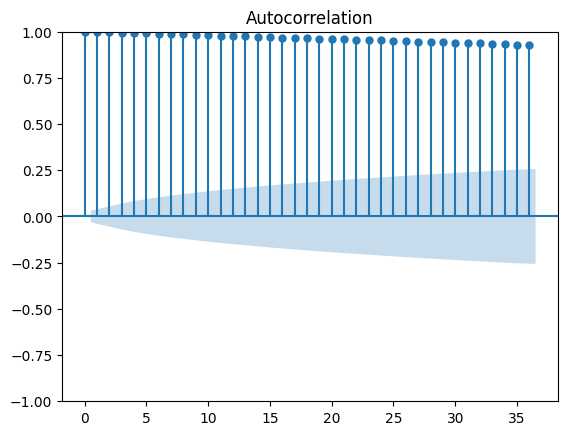

In [11]:
plot_acf(df['Close'])
plt.show()

Для більш точного прогнозування потрібно перетворити ряд таким чином, щоб зробити його стаціонарним. Для цього існує декілька способів, я вирішив використати пошук різниці (diff).

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data_diff = df.diff().dropna()

In [13]:
data_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-15,0.000000,-4.000000,0.50,0.500000,0.430939,-468200.0
2004-12-16,0.600006,1.500000,0.00,-0.399994,-0.344757,-124100.0
2004-12-17,-0.300003,-1.899994,-5.00,-2.600006,-2.241005,53500.0
2004-12-20,-2.300003,-2.100006,0.00,-1.300003,-1.120491,-57300.0
2004-12-21,-1.699997,-0.600006,0.00,1.600006,1.379074,-21100.0
...,...,...,...,...,...,...
2020-03-26,0.310000,-0.040000,0.26,-0.110000,-0.110000,-97400.0
2020-03-27,-0.170000,-0.460000,-0.47,-0.470000,-0.470000,-52500.0
2020-03-30,-0.220000,-0.140000,-0.14,-0.100000,-0.100000,5100.0


Перевіримо наш перетворений ряд на стаціонарність

In [14]:
data_diff.reset_index(inplace=True)
data_diff.columns.name = None

In [15]:
data_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850 entries, 0 to 3849
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3850 non-null   datetime64[ns]
 1   Open       3850 non-null   float64       
 2   High       3850 non-null   float64       
 3   Low        3850 non-null   float64       
 4   Close      3850 non-null   float64       
 5   Adj Close  3850 non-null   float64       
 6   Volume     3850 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 210.7 KB


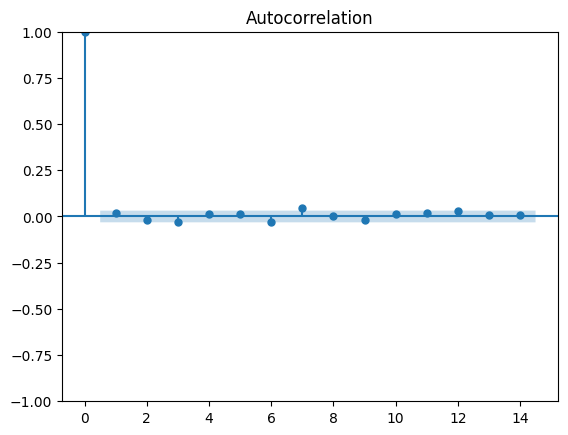

In [16]:
plot_acf(data_diff['Close'], lags=14)
plt.show()

Якщо лаги знаходяться за межами блакитної області, то ймовірно вони містять важливу інформацію. Ця область пов’язана з довірчим інтервалом. Загалом можна експериментувати з різним значенням лагу.

In [17]:
dickey_fuller_test(data_diff['Close'])

ADF Statistic: -11.778202789736396
p-value: 1.0500741655991948e-21
Ряд є стаціонарним.


Кореляція є дуже малою, тому складно обрати оптимальний розмір лагу. Я вирішив обрати значення 7, проводячи різні експрерименти воно показало найоптимльніші результати у відношенні точність/час прогнозування. Також я вирішив зробити лагування на Adj Close для кращої роботи моделі. До прикладу, ще можна використовувати Volume (об'єм) як допоміжну величину.

In [18]:
lag_size = 7
df_lagged = df.copy()
for lag in range(1, lag_size + 1):
    df_lagged[f'Close-lag-{lag}'] = df_lagged['Close'].shift(lag)

for lag in range(1, lag_size + 1):
    df_lagged[f'Adj Close-lag-{lag}'] = df_lagged['Adj Close'].shift(lag)

df_lagged = df_lagged.dropna()
df_lagged.reset_index(inplace=True)
df_lagged.columns.name = None

In [19]:
lag_features = []
for lag in range(1, lag_size + 1):
    lag_features.append(f'Close-lag-{lag}')

for lag in range(1, lag_size + 1):
    lag_features.append(f'Adj Close-lag-{lag}')

Тут встановлено значення shuffle=False для коректного поділу числового ряду.

In [20]:
df_curr = df_lagged[lag_features].copy()
df_curr['Close'] = df_lagged['Close'].copy()
df_original = df_lagged.copy()
features = ['Date']
features += lag_features
X_train, X_test, y_train, y_test = train_test_split(df_original[features], df_original['Close'], train_size=0.8, shuffle=False)

Реалізуємо функцію для walk forward методології

In [21]:
# Function for walk-forward validation
def walk_forward_validation(model, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, window:int = 15):
    predictions = []
    scaler = MinMaxScaler() # Мін макс нормалізація
    # Прохід по набору даних
    for i in range(0, len(X_test), window):
        X_window = X_test.iloc[i:i+window].drop(columns=['Date'])
        y_window = y_test.iloc[i:i+window]
        train_X = pd.concat([X_train, X_test.iloc[:i]])
        train_y = pd.concat([y_train, y_test.iloc[:i]])
        # Нормалізація даних
        scaler.fit(train_X.drop(columns=['Date']))
        train_X_scaled = scaler.transform(train_X.drop(columns=['Date']))
        X_window_scaled = scaler.transform(X_window)
        # Навчання моделі
        model.fit(train_X_scaled, train_y)
        window_predictions = model.predict(X_window_scaled)
        predictions.extend(window_predictions)
    return predictions

Функція для візуалізації

In [22]:
def plot_actual_predict(label: str, date: pd.DataFrame, y_true: np.array, predicted_y: list):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=date['Date'], y=y_true.values, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=date['Date'], y=predicted_y, mode='lines', name=label))
    fig.update_layout(title='Predicted vs Actual ' + str(label),
                      xaxis_title='Date',
                      yaxis_title='Price')
    fig.show()


Функція для обрахунку метрик

In [23]:
def get_metrics(model_name: str, y_true: np.array, y_predicted: np.array):
    mse_value = mean_squared_error(y_true, y_predicted)
    mae_value = mean_absolute_error(y_true, y_predicted)
    r2_value = r2_score(y_true, y_predicted)

    print(f"{model_name} :")
    print("Mean Squared Error (MSE) on test set:", mse_value)
    print("Mean Absolute Error (MAE) on test set:", mae_value)
    print("R^2 score on test set:", r2_value)

## Linear Regression

In [24]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg_predictions = walk_forward_validation(linear_reg, X_train, y_train, X_test)
get_metrics('Linear Regression', y_test, linear_reg_predictions)

Linear Regression :
Mean Squared Error (MSE) on test set: 3.0633430747361365
Mean Absolute Error (MAE) on test set: 1.3592061092872258
R^2 score on test set: 0.9729785680673645


Візуалізуємо прогнозовану ціну та актуальну

In [25]:
plot_actual_predict('Linear Regression', X_test, y_test, linear_reg_predictions)

## Random Forest Regression

In [26]:
# Random Forest Regression
rf_model = RandomForestRegressor()
rf_predictions = walk_forward_validation(rf_model, X_train, y_train, X_test)
get_metrics('Random Forest Regression', y_test, rf_predictions)

Random Forest Regression :
Mean Squared Error (MSE) on test set: 1.6469043707034043
Mean Absolute Error (MAE) on test set: 0.7296309429461376
R^2 score on test set: 0.9854728271477216


Візуалізуємо прогнозовану ціну та актуальну

In [27]:
plot_actual_predict('Random Forest Regression', X_test, y_test, rf_predictions)

Можемо бачити що RF впорався краще ніж LR

## LSTM-DNN

Реалізуємо функцію для walk-forward методології для нейронних мереж

In [28]:
# Function for walk-forward validation
def walk_forward_validation(model, X_train, y_train, X_test, y_test, window=15):
    predictions = []
    # Прохід по набору даних
    for i in range(0, len(X_test), window):
        X_window = X_test.iloc[i:i+window].drop(columns=['Date'])
        y_window= y_test.iloc[i:i+window]
        train_X = pd.concat([X_train, X_test.iloc[:i]])
        train_y = pd.concat([y_train, y_test.iloc[:i]])

        # Нормалізація даних
        scaler = MinMaxScaler()
        train_X_scaled = scaler.fit_transform(train_X.drop(columns=['Date']))
        X_window_scaled = scaler.transform(X_window)

        # Зміна розмірності для коректної роботи моделі
        train_X_reshaped = train_X_scaled.reshape((train_X_scaled.shape[0], train_X_scaled.shape[1], 1))
        X_window_reshaped = X_window_scaled.reshape((X_window_scaled.shape[0], X_window_scaled.shape[1], 1))
        # Навчання моделі
        model.fit(train_X_reshaped, train_y, epochs=20, batch_size=32, verbose=0)
        window_predictions = model.predict(X_window_reshaped)
        predictions.extend(window_predictions)
    return predictions

Використаємо Баєсовий оптимізатор для пошуку оптимальних гіперпараметрів нейромережі

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=16),
                   input_shape=(X_train.shape[1] - 1, 1),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=512, step=16)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss="mse", optimizer="adam")
    return model


tuner = kt.BayesianOptimization(build_model,
                                objective='val_loss',
                                max_trials=20,
                                directory='my_dir',
                                project_name='model_lstm_dnn_hyperparameter_optimization')

# Пошук оптимальних гіперпараметрів
tuner.search(X_train.drop(columns=['Date']), y_train,
             epochs=10,
             validation_data=(X_test.drop(columns=['Date']), y_test))

# Отримання найкращих гіперпараметрів
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 00m 15s]
val_loss: 1.8701130151748657

Best val_loss So Far: 1.4916030168533325
Total elapsed time: 00h 05m 05s


In [ ]:
# Побудова моделі з найкращими гіперпараметрами
model = tuner.hypermodel.build(best_hps)

# Model summary
model.summary()

lstm_predictions = walk_forward_validation(model, X_train, y_train, X_test, y_test)
get_metrics('LSTM-DNN', y_test, lstm_predictions)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 7, 512)            1052672   
                                                                 
 dropout_2 (Dropout)         (None, 7, 512)            0         
                                                                 
 lstm_3 (LSTM)               (None, 368)               1296832   
                                                                 
 dropout_3 (Dropout)         (None, 368)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 369       
                                                                 
Total params: 2349873 (8.96 MB)
Trainable params: 2349873 (8.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [===========

Можемо бачити, що нейронна мережа впоралась краще ніж RF та LR

Візуалізуємо прогнозовану ціну та актуальну

In [ ]:
predictions_list = [float(prediction[0]) for prediction in lstm_predictions]
plot_actual_predict('LSTM-DNN', X_test, y_test, predictions_list)

## CONV1D-LSTM-DNN

Аналогічно до попереднього випадку будуємо модель, використовуючи Баєсовий оптимізатор

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('conv_filters', min_value=8, max_value=64, step=16),
                     kernel_size=hp.Int('conv_kernel', min_value=2, max_value=5, step=1),
                     activation='relu',
                     input_shape=(X_train.shape[1] - 1, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=16), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.8, step=0.1)))
    model.add(LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=512, step=64)))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.1)))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    return model


tuner = kt.BayesianOptimization(build_model,
                                objective='val_loss',
                                max_trials=20,
                                directory='my_dir',
                                project_name='conv_1d_lstm_dnn_hyperparameter_optimization')

# Пошук оптимальних гіперпараметрів
tuner.search(X_train.drop(columns=['Date']), y_train,
             epochs=20,
             validation_data=(X_test.drop(columns=['Date']), y_test))

# Отримання найкращих гіперпараметрів
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from my_dir/conv_1d_lstm_dnn_hyperparameter_optimization/tuner0.json


In [ ]:
# Побудова моделі з найкращими гіперпараметрами
model = tuner.hypermodel.build(best_hps)

# Model summary
model.summary()

cnn_lstm_predictions = walk_forward_validation(model, X_train, y_train, X_test, y_test)
get_metrics('Conv1d-LSTM-DNN', y_test, cnn_lstm_predictions)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 16)             48        
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 16)             0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 3, 144)            92736     
                                                                 
 lstm_3 (LSTM)               (None, 96)                92544     
                                                                 
 flatten_1 (Flatten)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                      

Візуалізуємо прогнозовану ціну та актуальну

In [ ]:
predictions_list = [float(prediction[0]) for prediction in cnn_lstm_predictions]
plot_actual_predict('Conv1d-LSTM-DNN', X_test, y_test, predictions_list)

Conv1d-LSTM-DNN впоралась гірше ніж LSTM-DNN. Можливо, архітектура Conv1D-LSTM-DNN потребує подальшої оптимізації, до прикладу зміна кількості шарів, розмірів фільтрів для Conv1D, тощо. Також вибір оптимальної мережі залежить від особливостей датасет, методу прогнозування, цільової змінної тощо. Аналізуючи усі моделі, найкраще появила себе LSTM-DNN, найгірше - LR.